# Spectroscopic Data Reduction Part 2: Wavelength Calibration

This notebook assumes you've completed the Spectroscopic Trace process (see [Part 1](1-SpectroscopicTraceTutorial.ipynb)) and have a trace model handy.

## Authors
Adam Ginsburg, Kelle Cruz, Lia Corrales, Jonathan Sick, Adrian Price-Whelan

## Learning Goals
* Extract calibration lamp spectra from two-dimensional spectral images
* Fit a wavelength solution


## Keywords
Spectroscopy

## Summary
This tutorial will walk through extraction of a calibration lamp spectrum using an existing trace.

It will then demonstrate line identification using the NIST line list database.

Finally, it will show how to fit a wavelength solution to a calibration spectrum, integrating information from multiple calibration lamps.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
IPython
numpy
pillow
matplotlib



In [2]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'  # we want to show images, not matrices, so we set the origin to the lower-left
plt.style.use('dark_background')  # Optional configuration: if run, this will look nice on dark background notebooks

In [3]:
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist

We have three calibration lamp spectra: Mercury, Krypton, and Neon.  These are saved as .bmp (bitmap) files.

In [4]:
hg_filename = "hg_lamp_1-sixteenth_s.bmp"
kr_filename = "kr_lamp_p6.bmp"
ne_filename = "ne_lamp_1s.bmp"

In [5]:
hg_image = np.array(PILImage.open(hg_filename))
kr_image = np.array(PILImage.open(kr_filename))
ne_image = np.array(PILImage.open(ne_filename))

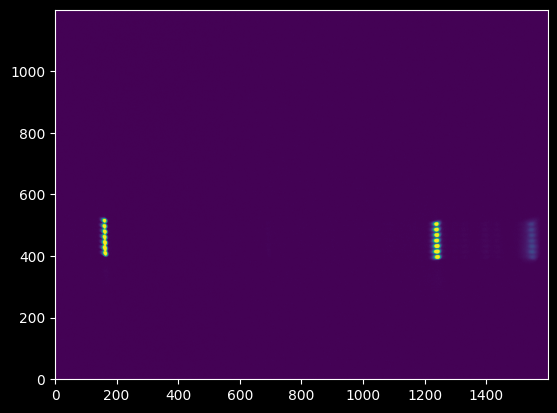

In [6]:
plt.imshow(hg_image);

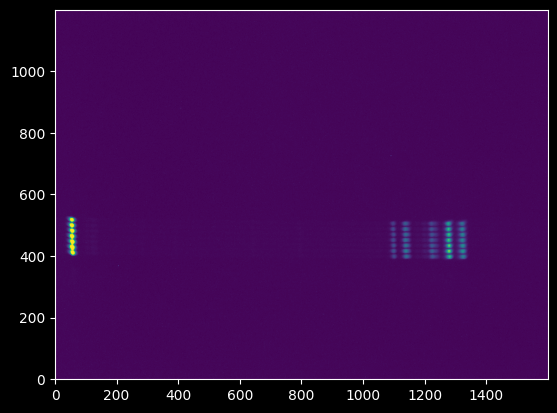

In [7]:
plt.imshow(kr_image);

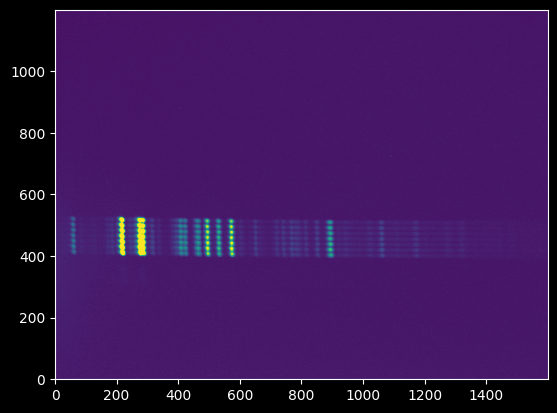

In [8]:
plt.imshow(ne_image);

We can note by zooming in that there appear to be seven independent spectra:

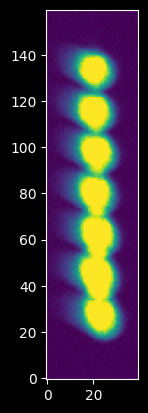

In [9]:
plt.imshow(hg_image[380:540,140:180]);

We re-create our trace model from the [Spectroscopic Trace Tutorial](Spectroscopic%20Trace%20Tutorial.ipynb) using the fitted models.

(We could have used the empirical trace directly, which might result in slightly improved noise characteristics, but for simplicity - and to make the two notebooks independently usable - we use the fitted polynomial & Gaussian models here)

In [10]:
trace_model = Polynomial1D(degree=3, c0=453.6307, c1=-0.01596396, c2=0.0000008259, c3=3.3348554642250357e-09)
trace_profile_model = Gaussian1D(amplitude=123.84846797, mean=0.17719819, stddev=5.10872134)
xaxis = np.arange(hg_image.shape[1])
trace_center = trace_model(xaxis)
npixels_to_cut=15
yaxis = np.arange(-npixels_to_cut, npixels_to_cut)
model_trace_profile = trace_profile_model(yaxis)

Then, we use the trace to extract spectra from each of the three calibration lamp spectra.

We verify that the traces look acceptable first, though:

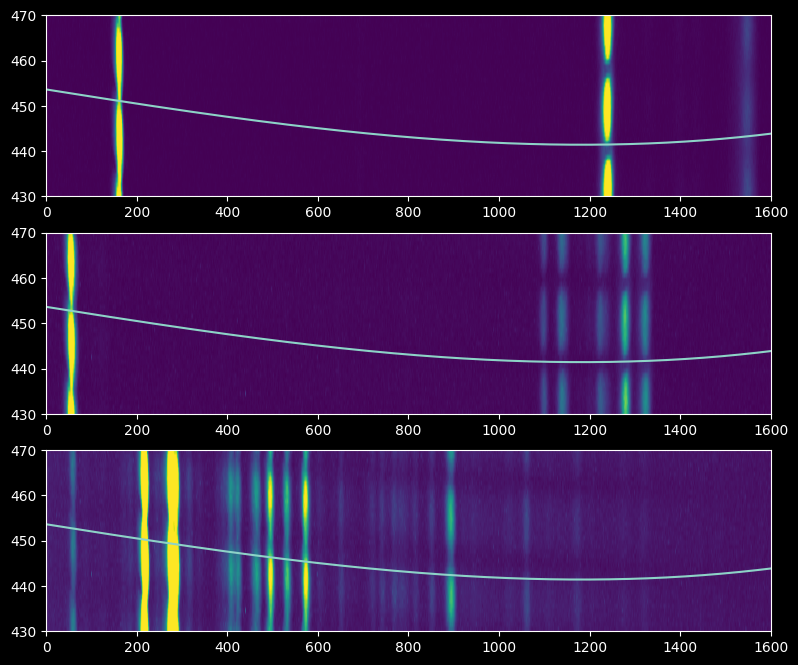

In [11]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot(3,1,1)
ax1.imshow(hg_image[430:470,:], extent=[0,1600,430,470])
ax1.plot(xaxis, trace_center)
ax1.set_aspect(10)
ax2 = plt.subplot(3,1,2)
ax2.imshow(kr_image[430:470,:], extent=[0,1600,430,470])
ax2.plot(xaxis, trace_center)
ax2.set_aspect(10)
ax3 = plt.subplot(3,1,3)
ax3.imshow(ne_image[430:470,:], extent=[0,1600,430,470])
ax3.plot(xaxis, trace_center)
ax3.set_aspect(10)

Strangely, the trace looks like it's going through a minimum between the individual spectra, which may indicate that the spectrograph was shaken or jiggled between the trace and wavelength calibration observations.  Nevertheless, there's enough signal that we can extract a calibration lamp spectrum, and the trace is perpendicular enough to the dispersion axis that we can mostly trust it. 

In the following three cells, we extract the trace-profile-weighted average spectrum from each of the three calibration lamps.  

``npixels_to_cut`` sets a cutout region around the trace, close to what is shown in the figures above.  The ``model_trace_profile``, derived earlier, is the transmission profile we measured using the stellar trace.  

In [12]:
hg_spectrum = np.array([np.average(hg_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [13]:
ne_spectrum = np.array([np.average(ne_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [14]:
kr_spectrum = np.array([np.average(kr_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

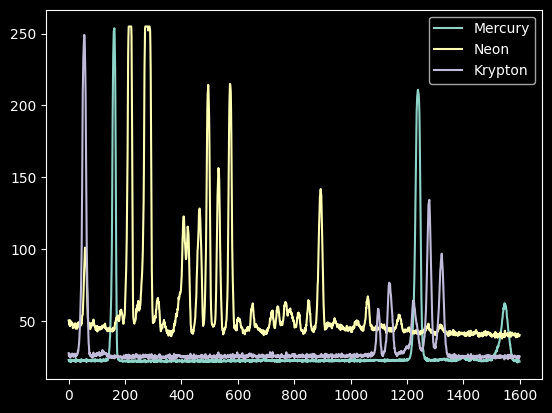

In [15]:
plt.plot(xaxis, hg_spectrum, label='Mercury')
plt.plot(xaxis, ne_spectrum, label='Neon')
plt.plot(xaxis, kr_spectrum, label='Krypton')
plt.legend(loc='best');

We now have spectra of a mercury lamp, a neon lamp, and a krypton lamp.

If we have no prior knowledge, we would have to do some guess-and-check.  It helps to do _educated_ guess-and-check, though; wikipedia is a decent resource to point us at the right line lists:

 * https://en.wikipedia.org/wiki/Mercury-vapor_lamp#Emission_line_spectrum
 * https://en.wikipedia.org/wiki/Gas-discharge_lamp#Color

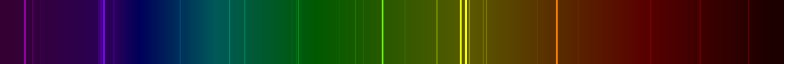

In [16]:
Image("https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg")

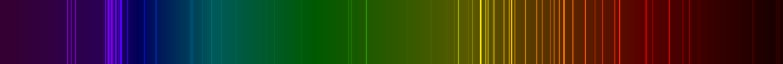

In [17]:
Image("https://upload.wikimedia.org/wikipedia/commons/9/99/Neon_spectra.jpg")

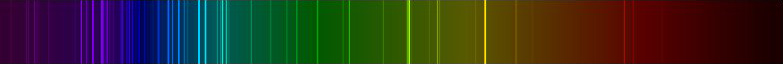

In [18]:
Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Krypton_Spectrum.jpg")

Start with mercury.  We use a different wikipedia spectrum that looks a little more like ours to guide the eye (note that the line ratios vary from lamp to lamp at least partly because each lamp contains gas at a different pressure).

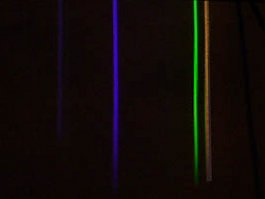

In [19]:
Image("https://upload.wikimedia.org/wikipedia/commons/0/0d/HG-Spektrum_crop.jpg")

The optical lines of Mercury are, from Wikipedia, in Angstroms:

 * 4047 violet
 * 4358 blue
 * 5461 green
 * 5782 yellow-orange
 * 6500 red

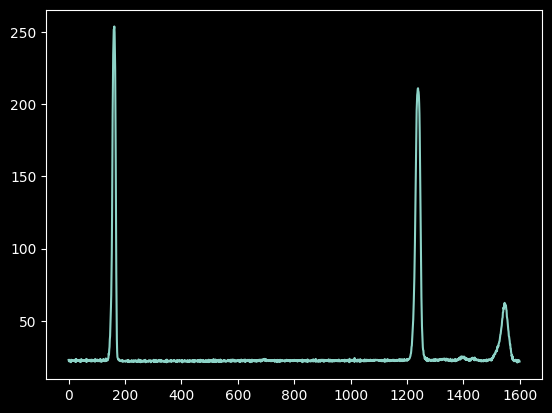

In [20]:
plt.plot(xaxis, hg_spectrum);

At this next step, we have to write down which (approximate) pixel values correspond to known wavelengths.

Guessing these just by looking at the spectra and comparing to spectral atlases is hard and takes experience.

If you have spectra taken with the same setup of a known sources - such as an A0 star - you might be able to use that to give you a 'prior' on where the spectrum is centered.
In this case, our set of spectra include Deneb, which is an A-star.  It has a clear absorption line (that we'll see later, in tutorial 3) around pixel 750.
A-stars have deep hydrogen absorption lines in their atmosphere and little else, so this is probably a hydrogen line.
We can assume it's either H-alpha or H-beta, since they are both in the optical and strong (higher lines, like H-delta, are all close together, so if it were one of them, we'd expect to see several adjacent lines).

We can therefore compare our spectrum to the atlases assuming pixel 750 is H-beta or H-alpha.  Using the line list, we can see red is pretty unlikely: H-alpha is at 6563, so there would be a line right next to it.  If it's H-beta, there are lines on either side, and there is a doublet on the right side.  

The next trick is figuring out which way the wavelength increases - to the left or the right?  Mercury doesn't help with that, since the blue-violet and green-yellow doublets are about the same distance from one another.  It turns out, from guess-and-check work, that wavelength is increasing to the left.

Again, this part is hard to do directly from the data - you generally hope to have a pretty good idea of what wavelength you're observing before you observe!

In [21]:
guessed_wavelengths = [546.1, 435.8, 404.7]
guessed_xvals = [165, 1230, 1550]

## Improving on our guesses

We can do a lot better at determining the pixel X-values by taking the intensity-weighted coordinate (moment 1):

In [22]:
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=hg_spectrum[g-npixels:g+npixels] - np.median(hg_spectrum))
                         for g in guessed_xvals]
improved_xval_guesses

[np.float64(160.736647147187),
 np.float64(1235.1743737214103),
 np.float64(1548.2834755459144)]

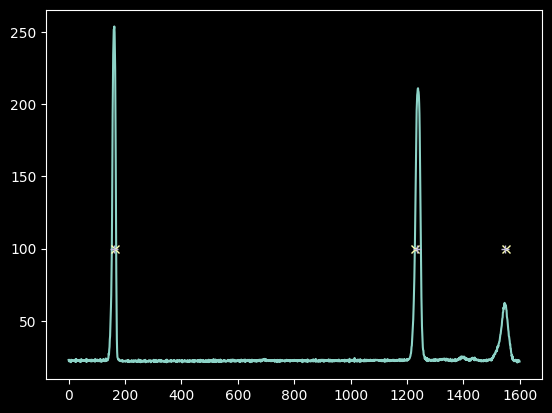

In [23]:
plt.plot(xaxis, hg_spectrum)
plt.plot(guessed_xvals, [100]*3, 'x')
plt.plot(improved_xval_guesses, [100]*3, '+');

We only have three data points, but that is enough to fit a linear model and still have a free point to check that we got it close to right:

In [24]:
linfitter = LinearLSQFitter()

We use a `Linear1D` model because we will want to use its inverse later (other models are not invertible)

In [25]:
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(xaxis) * u.nm
linfit_wlmodel

<Linear1D(slope=-0.10210002, intercept=562.40076754)>

Note this fitted slope: each pixel is about 0.1 nm (about 1 angstrom), and the wavelength increases to the left.

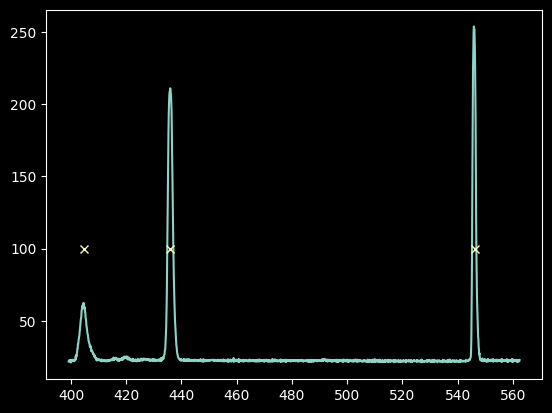

In [26]:
plt.plot(wavelengths, hg_spectrum)
plt.plot(guessed_wavelengths, [100]*3, 'x');

We show our model $\lambda(x)$ vs the input "guesses":

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3665/1925952792.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

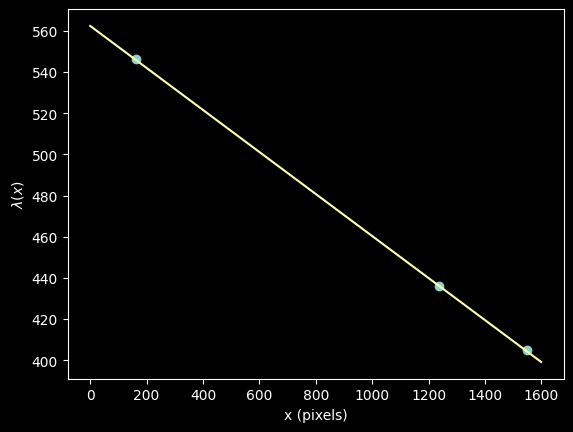

In [27]:
plt.plot(improved_xval_guesses, guessed_wavelengths, 'o')
plt.plot(xaxis, wavelengths, '-')
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

Indeed, a linear model fit excellently!

We can look up neon and krypton line lists to see how well we did and maybe try to improve our fit.

NIST, the National Institute of Standards and Technology, maintains [atomic line lists](https://physics.nist.gov/PhysRefData/ASD/lines_form.html).  However, we have no direct way to know which transitions from these atoms to use!  There are a few heuristics we can apply, though.

In [28]:
# we adopt the minimum/maximum wavelength from our linear fit
minwave = wavelengths.min()
maxwave = wavelengths.max()
# then we search for atomic lines
# We are only interested in neutral lines, assuming the lamps are not hot enough to ionize the atoms
mercury_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Hg I')
krypton_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Kr I')
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        linename='Ne I')

We can first look at what NIST reports for the mercury spectrum we already fit:

(note that the wavelengths are *air* wavelengths, not vacuum)

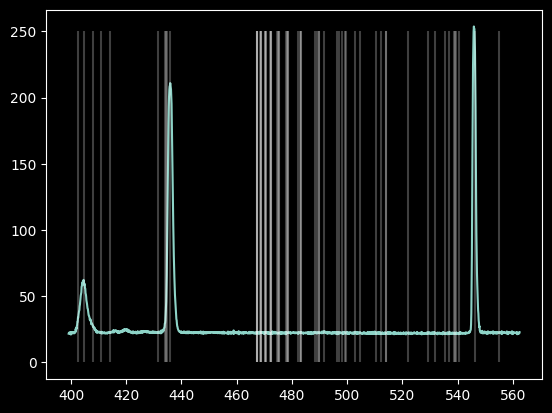

In [29]:
plt.plot(wavelengths, hg_spectrum)
plt.vlines(mercury_lines['Observed'], 0, 250, 'w', alpha=0.25);

The database contains *many* more lines than we saw.

The "Rel. Int" (Relative Intensity) provides "a qualitative description of what the emission spectrum of a particular element in a particular (low-density) source looks like." 

We can select that column, if we clean it up a little (there are some "blank" entries)

In [30]:
# these lines downselect from the table to keep only those that have usable "Relative Intensity" measurements
# first, we get rid of those whose 'Rel.' column is masked out or is an asterisk
hg_keep = (~mercury_lines['Rel.'].mask) & (mercury_lines['Rel.'] != "*")
hg_wl_tbl = mercury_lines['Observed'][hg_keep]
# then, we collect the 'Rel.' values and convert them from strings to floats
hg_rel_tbl = np.array([float(x) for x in mercury_lines['Rel.'][hg_keep]])

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3665/4267924989.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$ [nm]");


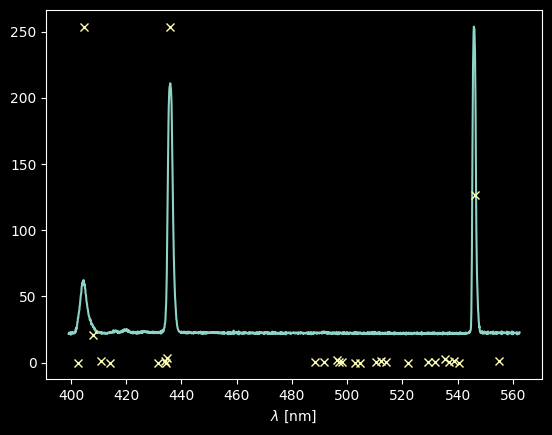

In [31]:
plt.plot(wavelengths, hg_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
plt.plot(hg_wl_tbl, hg_rel_tbl / hg_rel_tbl.max() * hg_spectrum.max(), 'x')
plt.xlabel("$\lambda$ [nm]");

Not bad!  See that only the three "brightest" lines show up, plus maybe a bit of a third one around 408 nm.

Let's try the same for the other lines (note that the hackery changes - this is because the NIST tables are not formatted to be machine-readable!)

In [32]:
ne_keep = np.array(['*' not in x for x in neon_lines['Rel.']])
ne_wl_tbl = neon_lines['Observed'][ne_keep]
ne_rel_tbl = np.array([float(x) for x in neon_lines['Rel.'][ne_keep]])

In [33]:
kr_keep = np.array([('*' not in x) and ('h' not in x) and ('-' not in x) for x in krypton_lines['Rel.']])
kr_wl_tbl = krypton_lines['Observed'][kr_keep]
kr_rel_tbl = np.array([float(x) for x in krypton_lines['Rel.'][kr_keep]])

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3665/514056980.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$ [nm]")


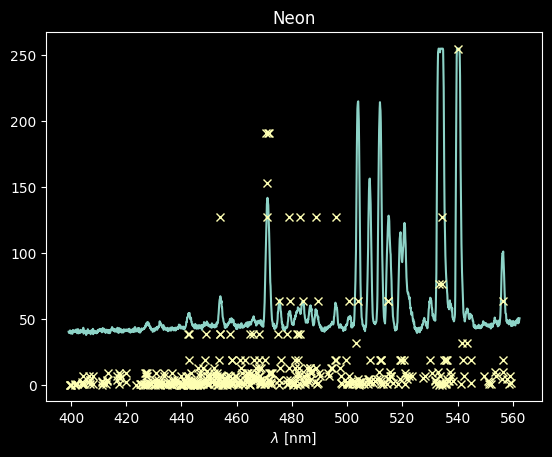

In [34]:
plt.plot(wavelengths, ne_spectrum)
plt.plot(ne_wl_tbl, ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max(), 'x')
plt.xlabel("$\lambda$ [nm]")
plt.title("Neon");

For Neon, there are many lines that match up, but a lot that don't match well (we detect a lot that have low `Rel` values)

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3665/1350297613.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$ [nm]")


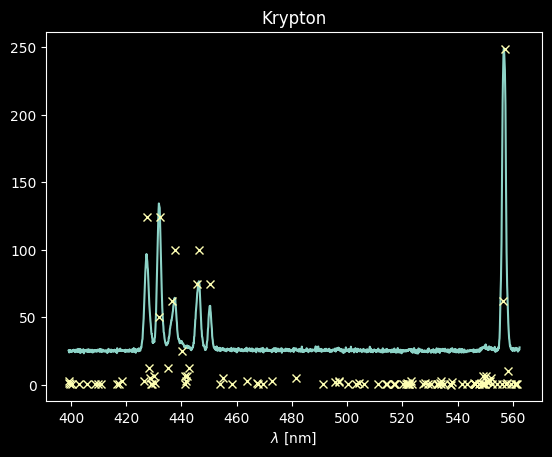

In [35]:
plt.plot(wavelengths, kr_spectrum)
plt.plot(kr_wl_tbl, kr_rel_tbl / kr_rel_tbl.max() * kr_spectrum.max(), 'x')
plt.xlabel("$\lambda$ [nm]")
plt.title("Krypton");

The Krypton spectrum will be much easier to deal with: we just select those lines with intensities > 70 on the scale above:

In [36]:
kr_rel_intens =  kr_rel_tbl / kr_rel_tbl.max() * kr_spectrum.max()
kr_keep_final = kr_rel_intens > 70
kr_wl_final = kr_wl_tbl[kr_keep_final]

We then take these krypton wavelengths and convert them back to pixel space:

In [37]:
# the linear model has an inverse function that takes y = m x + b and converts to x = (y - b) / m
kr_pixel_vals = linfit_wlmodel.inverse(kr_wl_final)

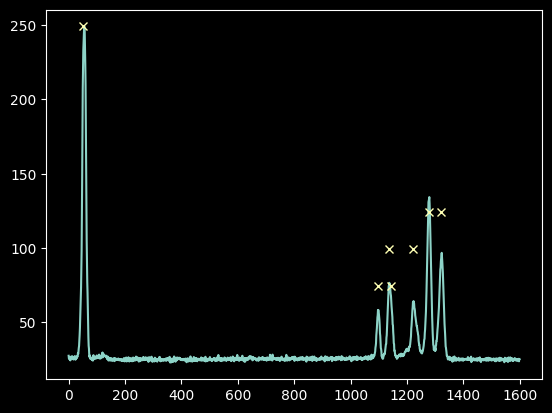

In [38]:
plt.plot(xaxis, kr_spectrum)
plt.plot(kr_pixel_vals, kr_rel_intens[kr_keep_final], 'x');

As with mercury above, we select a sub-region and measure the intensity-weighted peak position in pixel number to accurately measure the pixel center.

But here we have to be careful!  These peaks are very close!  Can we still use a +/-15 pixel range?

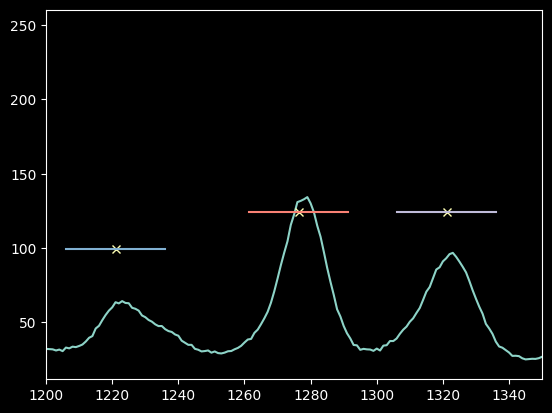

In [39]:
# Examine the pixel range, +/-15 pix, to see if it results in line overlaps
plt.plot(xaxis, kr_spectrum)
plt.plot(kr_pixel_vals, kr_rel_intens[kr_keep_final], 'x')
for xx, yy in zip(kr_pixel_vals, kr_rel_intens[kr_keep_final]):
    plt.plot([xx-15,xx+15], [yy,yy], ) # plot horizontal lines at each peak location
plt.xlim(1200,1350);

Yes, 15 pixels looks OK still.

If these lines had overlapped with one another at all, we would have wanted to decrease the pixel range.

In [40]:
# note that we have to force the pixel-center guesses to be integers for slicing:
npixels = 15
improved_xval_guesses_kr = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=kr_spectrum[g-npixels:g+npixels] - np.median(kr_spectrum))
                         for g in map(int, kr_pixel_vals)]
improved_xval_guesses_kr

[np.float64(1321.3688120277354),
 np.float64(1277.1972221744618),
 np.float64(1222.9735220981242),
 np.float64(1140.2780334574877),
 np.float64(1137.7518421055224),
 np.float64(1097.715582422276),
 np.float64(54.2769391627054)]

Now we can plot these best-fit pixel numbers against the "true" wavelengths and overplot our previous best-fit model from mercury:

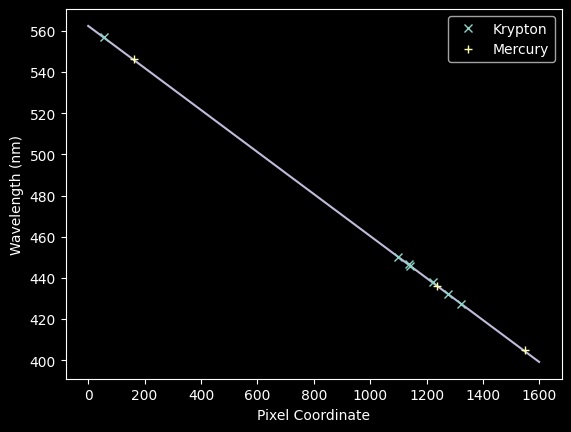

In [41]:
plt.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
plt.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
plt.plot(xaxis, wavelengths, zorder=-5)
plt.legend(loc='best')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength (nm)");

We can now jointly fit the Kr + Hg spectra with a new model:

In [42]:
# we concatenate the data sets together
xvals_hg_plus_kr = np.concatenate([improved_xval_guesses,
                                   improved_xval_guesses_kr])
waves_hg_plus_kr = np.concatenate([guessed_wavelengths, kr_wl_final])
linfit_wlmodel_hgkr = linfitter(model=wlmodel,
                                x=xvals_hg_plus_kr,
                                y=waves_hg_plus_kr)
linfit_wlmodel_hgkr

<Linear1D(slope=-0.10221918, intercept=562.56900643)>

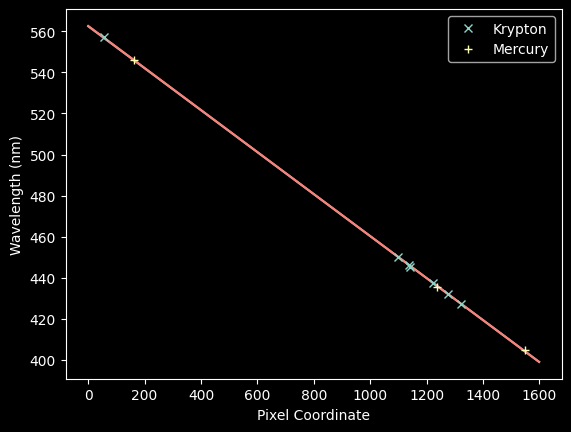

In [43]:
# re-plot the data with the fit overlaid
plt.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
plt.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
plt.plot(xaxis, wavelengths, zorder=-5)
plt.plot(xaxis, linfit_wlmodel_hgkr(xaxis), zorder=-5)
plt.legend(loc='best')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength (nm)");

These are nearly indistiguishable, but let's look at the residuals for each:

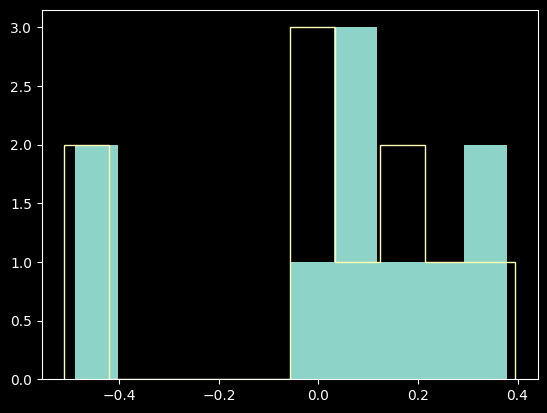

In [44]:
residuals_hgonlymodel = np.array(waves_hg_plus_kr) - linfit_wlmodel(xvals_hg_plus_kr)
residuals_hgkrmodel = np.array(waves_hg_plus_kr) - linfit_wlmodel_hgkr(xvals_hg_plus_kr)
plt.hist(residuals_hgonlymodel, label='Hg-only fit', histtype='stepfilled')
plt.hist(residuals_hgkrmodel, label='Hg-only fit', histtype='step');

The differences are pretty marginal; the Hg-only fit was really good.

Is there any shape to the residuals?

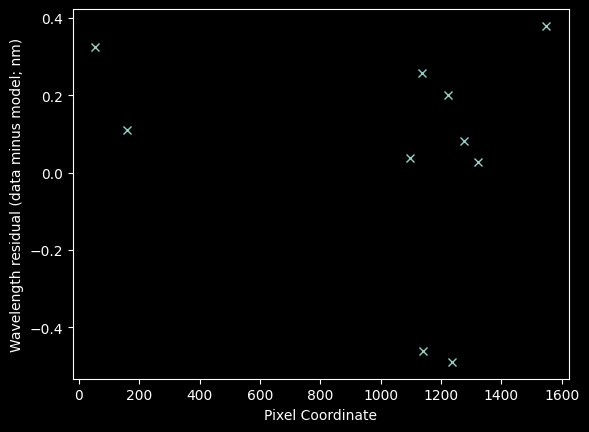

In [45]:
plt.plot(xvals_hg_plus_kr, residuals_hgonlymodel, 'x')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength residual (data minus model; nm)");

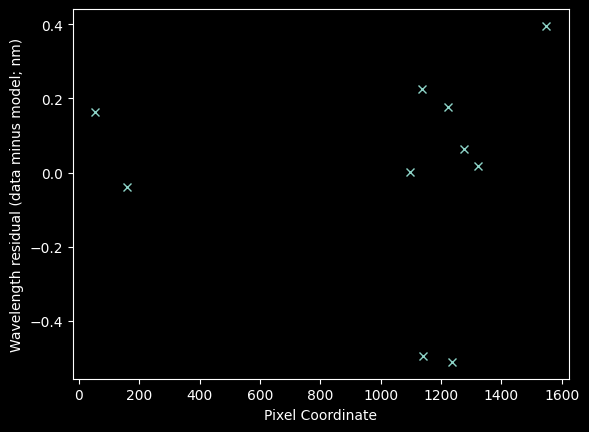

In [46]:
plt.plot(xvals_hg_plus_kr, residuals_hgkrmodel, 'x')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength residual (data minus model; nm)");

In brief, no, there's no sign of structure.  If there were, we might want to fit a higher-order model.

We can also estimate a chi-squared-like statistic (though note that this is *not* the $\chi^2$ value we would use to assess goodness of fit because we have *not* estimated the uncertainty on each wavelength point!)

In [47]:
resid2_hgonly = (residuals_hgonlymodel**2).sum()
resid2_hgkr = (residuals_hgkrmodel**2).sum()
resid2_hgonly, resid2_hgkr

(np.float64(0.8290377437520076), np.float64(0.7755414146718549))

These differences are also very small, again suggesting the Hg-only fit was really good.

Why do we bother going through all these checks if the Hg-only fit was just fine?  

Besides simply not knowing, it is common for spectrographs to have slightly non-linear dispersion when measured over a wide wavelength range, so we want to be sure we haven't missed any such curvature.

We also want to measure the uncertainty on our wavelength calibration.

Now let's go back and measure the Neon spectrum

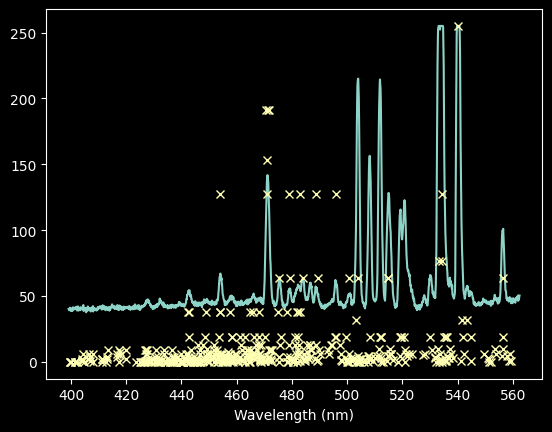

In [48]:
ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max()
plt.plot(wavelengths, ne_spectrum)
plt.plot(ne_wl_tbl, ne_rel_intens, 'x')
plt.xlabel('Wavelength (nm)');

We can try keeping only those with intensiy >100, though we will miss some lines

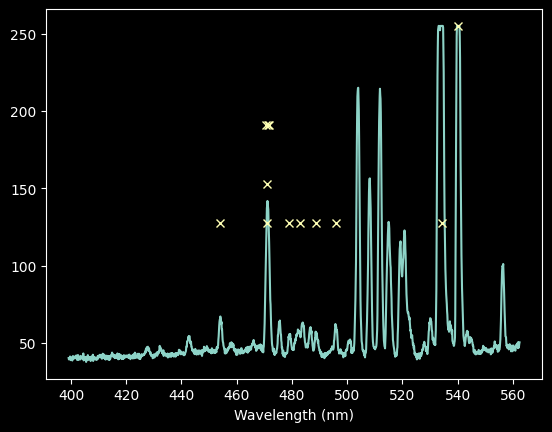

In [49]:
ne_keep_final = ne_rel_intens > 100
plt.plot(wavelengths, ne_spectrum)
plt.plot(ne_wl_tbl[ne_keep_final], ne_rel_intens[ne_keep_final], 'x')
plt.xlabel('Wavelength (nm)');

In [50]:
# select down to just those lines we want to keep
ne_wl_final = ne_wl_tbl[ne_keep_final]
ne_pixel_vals = linfit_wlmodel.inverse(ne_wl_final)

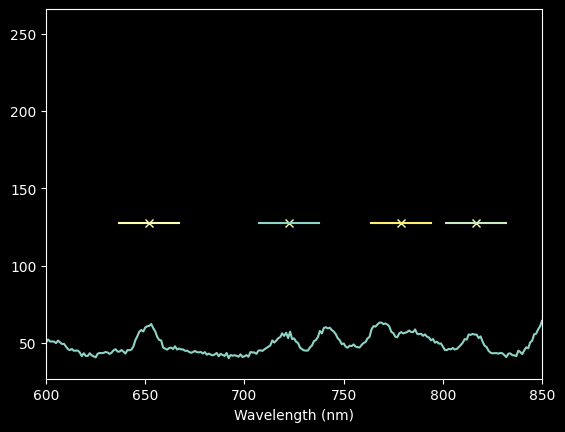

In [51]:
# check for overlaps again (in the densest part of the spectrum)
plt.plot(xaxis, ne_spectrum)
plt.plot(ne_pixel_vals, ne_rel_intens[ne_keep_final], 'x')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    plt.plot([xx-15,xx+15], [yy,yy], )
plt.xlim(600,850)
plt.xlabel('Wavelength (nm)');

For Neon, our automated approach isn't very good (the third point from the left is not on a peak), and we'll want to use a narrower pixel range.

Still, rather than go back through and laboriously identify each line, we'll stick with a semi-automated approach, just using a narrower range around each peak.

In [52]:
npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in map(int, ne_pixel_vals)]
improved_xval_guesses_ne

[np.float64(1060.5183193475166),
 np.float64(895.2424884504669),
 np.float64(893.670848263007),
 np.float64(892.9232835842486),
 np.float64(892.082009702997),
 np.float64(890.6754750779604),
 np.float64(814.5085554585149),
 np.float64(776.6287593955387),
 np.float64(720.1158679501369),
 np.float64(651.4261979644568),
 np.float64(275.48231610553455),
 np.float64(216.88320524067413)]

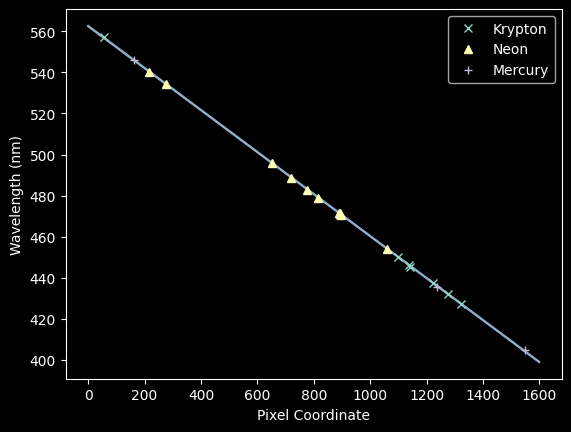

In [53]:
plt.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
plt.plot(improved_xval_guesses_ne, ne_wl_final, '^', label='Neon')
plt.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
plt.plot(xaxis, wavelengths, zorder=-5)
plt.plot(xaxis, linfit_wlmodel_hgkr(xaxis), zorder=-5)
plt.legend(loc='best')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength (nm)");

We concatenate the Neon lines onto the spectrum and re-fit again

In [54]:
xvals_hg_plus_kr_plus_ne = list(improved_xval_guesses) + list(improved_xval_guesses_kr) + list(improved_xval_guesses_ne)
waves_hg_plus_kr_plus_ne = list(guessed_wavelengths) + list(kr_wl_final) + list(ne_wl_final)
linfit_wlmodel_hgkrne = linfitter(model=wlmodel, x=xvals_hg_plus_kr_plus_ne, y=waves_hg_plus_kr_plus_ne)
linfit_wlmodel_hgkrne

<Linear1D(slope=-0.10213663, intercept=562.38704084)>

In [55]:
residuals_hgmodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel(xvals_hg_plus_kr_plus_ne)
residuals_hgkrmodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel_hgkr(xvals_hg_plus_kr_plus_ne)
residuals_hgkrnemodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel_hgkrne(xvals_hg_plus_kr_plus_ne)

In [56]:
# calculate and compare the squared residuals
# the model calculated for Hg-only works better than that for Krypton, but the optimal linear model is calculated
# from all data, with a squared residual of 1.26 nm
resid2_hgonly = (residuals_hgmodel_nedata**2).sum()
resid2_hgkr = (residuals_hgkrmodel_nedata**2).sum()
resid2_hgkrne = (residuals_hgkrnemodel_nedata**2).sum()
resid2_hgonly, resid2_hgkr, resid2_hgkrne

(np.float64(1.2974244674712048),
 np.float64(1.5361995410991647),
 np.float64(1.2470951152669452))

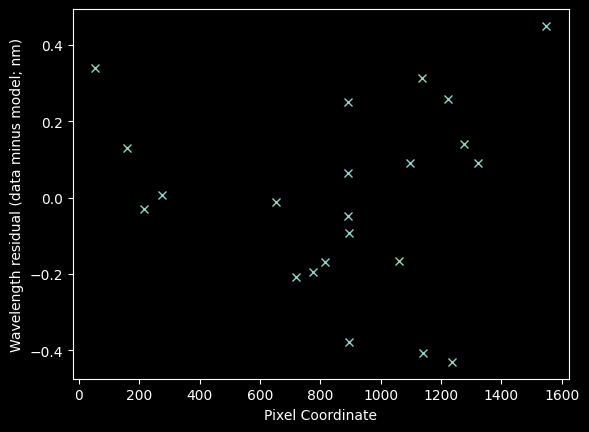

In [57]:
plt.plot(xvals_hg_plus_kr_plus_ne, residuals_hgkrnemodel_nedata, 'x')
plt.xlabel("Pixel Coordinate")
plt.ylabel("Wavelength residual (data minus model; nm)");

Finally, with neon included, there is a hint of some structure

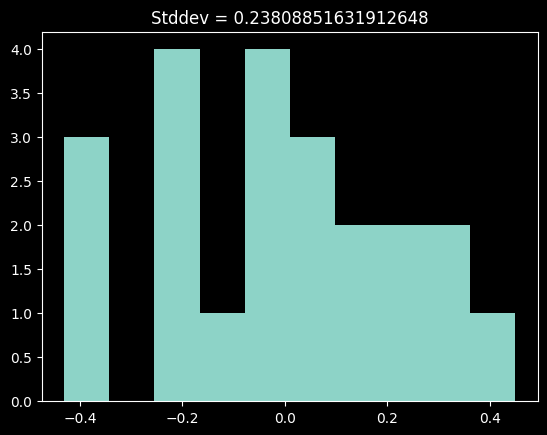

In [58]:
plt.hist(residuals_hgkrnemodel_nedata)
plt.title(f"Stddev = {residuals_hgkrnemodel_nedata.std()}");

This histogram is perhaps a little skewed.

There may be some curvature to this spectrum, but the evidence is not terribly compelling, particularly given the uncertain nature of the Neon line fits.

The scatter in these residuals comes out to ~0.24 nm.  We'll examine this value further below.

## Measuring the uncertainty of the wavelength solution

To evaluate our uncertainty, let's first look at the uncertainty in the pixel value inferred from looking at a single line in the mercury spectrum.

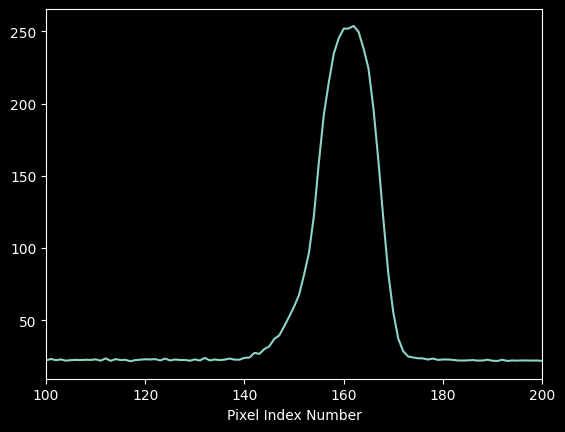

In [59]:
plt.plot(xaxis, hg_spectrum)
plt.xlim(100,200)
plt.xlabel("Pixel Index Number");

We can get a *coarse* empirical estimate of the per-pixel uncertainty by taking the standard deviation of a "blank" part of the spectrum:

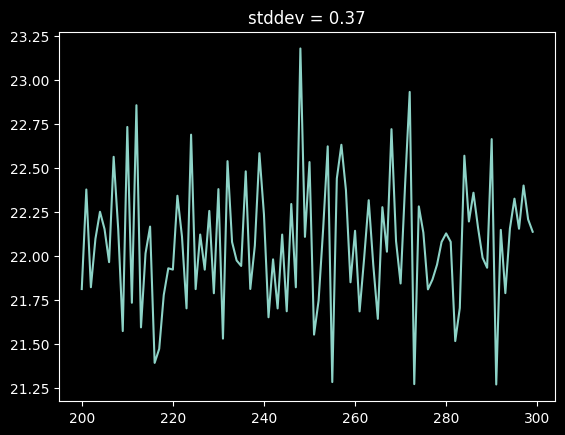

In [60]:
plt.plot(xaxis[200:300], hg_spectrum[200:300])
noise_estimate = hg_spectrum[200:300].std()
plt.title(f"stddev = {noise_estimate:0.2f}");

The moment-1 estimate of the peak location is, for a spectrum $f(x)$ and pixel location $x$ 
$$ m_1 = \frac{\Sigma x f(x)}{\Sigma f(x)} $$

which, through propagation of error, gives us variance of moment 1:

$$\sigma_{m_1}^2 =  \left(\frac{\Sigma \left[ (x-m_1)^2   \sigma_{f(x)}^2 \right]}{\left(\Sigma f(x)\right)^2}  +
   \frac{\sigma_{\Sigma f(x)}^2 \Sigma \left[ (x-m_1)^2 f(x)^2 \right]}{\left(\Sigma f(x)\right)^4} \right)$$
   
   where 
$   \sigma_{\Sigma f(x)}^2 = \Sigma \sigma_{f(x)}^2 = N \sigma_{f(x)}^2 $

In [61]:
cutout = hg_spectrum[100:200] - np.median(hg_spectrum)
xcutout = xaxis[100:200]
m1 = (xcutout * cutout).sum() / cutout.sum()
m1

np.float64(160.14071738720793)

In [62]:
# Uncertainty on moment 1
sigma_m1_left = ((xcutout-m1)**2 * noise_estimate**2).sum() / cutout.sum()**2
sigma_m1_right = (xcutout.size * noise_estimate**2) * ((xcutout-m1)**2*cutout**2).sum() / cutout.sum()**4
sigma_m1 = sigma_m1_left + sigma_m1_right
sigma_m1

np.float64(0.0012527166750909403)

In [63]:
print(f"Moment analysis yields m1 = {m1:0.3f} +/- {sigma_m1:0.3f} pixels")

Moment analysis yields m1 = 160.141 +/- 0.001 pixels


The uncertainty is about 1/1000th of a pixel for a bright line.  It may be somewhat larger for fainter lines, but it is still much smaller than our observed scatter. 

 We can prove that the uncertainty per line is negligible by looking at a faint neon line:

In [64]:
# cut out a line and compute its moment 1
cutoutne = ne_spectrum[640:660] - np.median(ne_spectrum)
xcutoutne = xaxis[640:660]
m1ne = (xcutoutne * cutoutne).sum() / cutoutne.sum()

In [65]:
# estimate the per-pixel error in the Neon spectrum
ne_noise_estimate = ne_spectrum[1400:1600].std()
ne_noise_estimate

np.float64(1.0704108932039562)

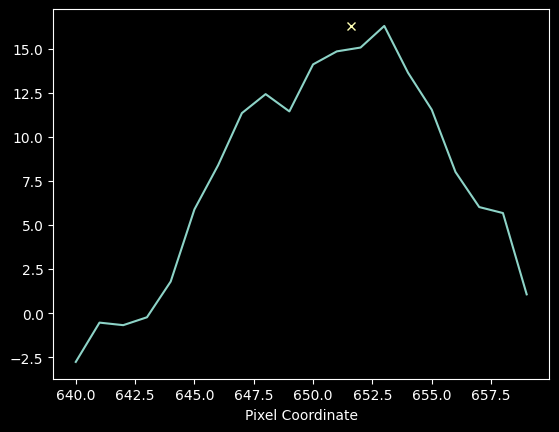

In [66]:
plt.plot(xcutoutne, cutoutne)
plt.plot(m1ne, cutoutne.max(), 'x')
plt.xlabel("Pixel Coordinate");

In [67]:
# calculate Neon line centroid uncertainty
sigma_m1_left = ((xcutoutne-m1ne)**2 * ne_noise_estimate**2).sum() / cutoutne.sum()**2
sigma_m1_right = (xcutoutne.size * ne_noise_estimate**2) * ((xcutoutne-m1ne)**2*cutoutne**2).sum() / cutoutne.sum()**4
sigma_m1_ne = sigma_m1_left + sigma_m1_right
sigma_m1_ne

np.float64(0.03746963744056958)

In [68]:
print(f"Moment analysis for the faint Neon line yields m1 = {m1ne:0.4f} +/- {sigma_m1_ne:0.4f} pixels")

Moment analysis for the faint Neon line yields m1 = 651.6098 +/- 0.0375 pixels


This error is ~40 times larger, but still much less than a pixel's width.

Our best fit gives that each pixel is about 0.1 nm (this comes from the slope of the fitted line), so our uncertainty is 0.0001 nm - 0.004 nm.  The scatter in the residuals is 0.23 nm, so it is not explained by our formal fit's statistical uncertainty. 

In [69]:
print(f"Standard Deviation of the residuals = {residuals_hgkrnemodel_nedata.std()} nm, "
      f"Faint Line uncertainty = {sigma_m1_ne * linfit_wlmodel_hgkrne.slope} nm")

Standard Deviation of the residuals = 0.23808851631912648 nm, Faint Line uncertainty = -0.003827022578147107 nm


## What does the residual represent?

The residual to our fit gives us a sense of the *systematic* uncertainty from a combination of line blending and imperfect fits.  We know, from the NIST line lists, that there are in some cases multiple lines that we could not easily distinguish in the spectrum: these add a small bias to our inferred pixel locations.

There may also be subtle effects from the spectrograph itself that cause small systematic variations in the wavelength solution.

## How could we do better?

We could attempt to *deblend* the individual spectral features by jointly fitting multiple-Gaussian models.

While this procedure is commonly used, it is fraught with error and extremely difficult to automate in general.

You're done!  Now apply this calibration to the data and start measuring things in Tutorial 3